# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [314]:
%matplotlib inline

import pylab as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import statsmodels.api as sm
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

from sklearn.cluster import KMeans

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

# get rid if scientific notation. hate it
pd.set_option('display.float_format', lambda x: '%.3f' % x)

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x15b46ef90>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

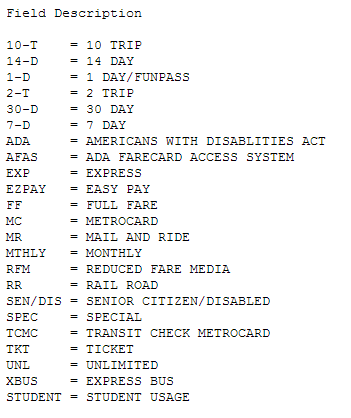

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [3]:
mta = np.load("MTA_Fare.npy")
mta = mta.astype(float)
mta.shape

(600, 23, 194)

In [4]:
# cleaning data
mta[mta==-1] = np.nan

In [5]:
#indexes
dates = pd.date_range(start='05/21/2010', periods=194, freq='W')
sts = ['st%i'% x for x in xrange(1,601)]

ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])


In [6]:
# now reconfiguring data
dp  = pd.Panel(mta)

# timeseries need to be a major axis (vertical)
dp = dp.transpose(0, 2, 1)

# name all indexes
dp.rename(items=pd.Series(sts), major_axis = pd.Series(dates), minor_axis=pd.Series(ridetype), inplace=1)

In [7]:
dp

<class 'pandas.core.panel.Panel'>
Dimensions: 600 (items) x 194 (major_axis) x 23 (minor_axis)
Items axis: st1 to st600
Major_axis axis: 2010-05-23 00:00:00 to 2014-02-02 00:00:00
Minor_axis axis: 10t to stud

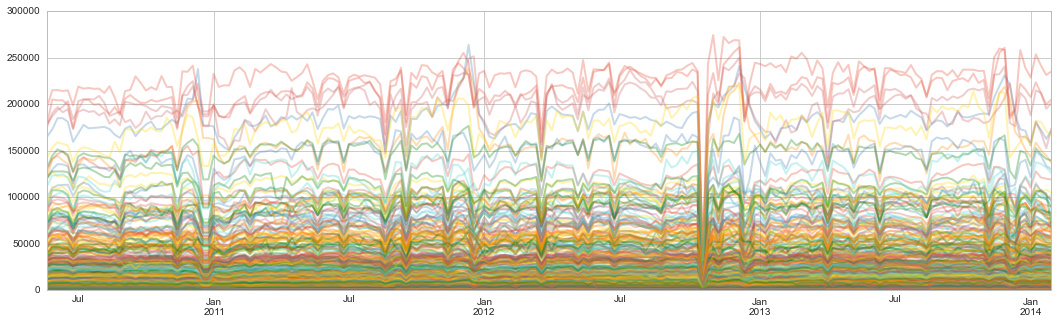

In [16]:
ax = dp['st1'].plot(figsize=(18,5), legend=0, alpha=.3)     # use first as plot for others

for st in dp[1:100]:                                        # for the sake of timesaving, only few first
    dp[st].plot(ax=ax, legend=0, alpha=.3)


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


1 events detected:

2012-10-21    23728
Name: 10t, dtype: float64

3 events detected:

2012-10-21     5566
2012-12-16    34500
2012-12-23    34178
Name: 10t, dtype: float64

3 events detected:

2011-12-04    227842
2011-12-11    238597
2012-10-21     13350
Name: 10t, dtype: float64

1 events detected:
[Timestamp('2012-10-21 00:00:00')]


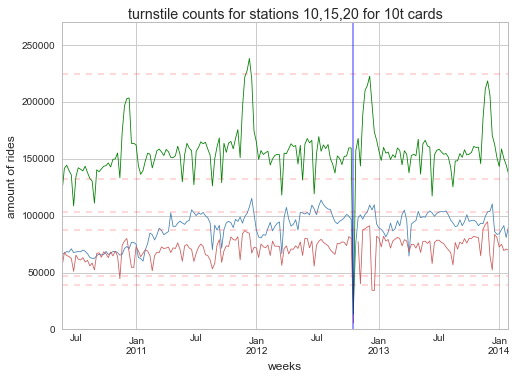

In [165]:
def getThreshold(ser, zscore=3.0):
    '''returns event threshold for given series and Z-score'''
    thresholds = [ser.mean() - zscore*ser.std(),
                  ser.mean() + zscore*ser.std()]
    
    return thresholds



def getEvent(ser, ths):
    '''returns dates of event basing on threshold'''
    ed = ser[(ser<ths[0])|(ser>ths[1])]

    if len(ed)==0:
        print '\nNone events detected'
        return
    else:
        print '\n%i events detected:' % len(ed)
        print
        print ed
        return ed

def detectEvent(ser, zscore=3, plotEvents=True):
    ths = getThreshold(ser, zscore=zscore)
    events=getEvent(ser,ths)

    
    ax = ser.plot( lw=.8)
    ax.plot( [ax.get_xlim()[0], ax.get_xlim()[1]],[ths[1]]*2, 'r--', lw=.3)
    ax.plot( [ax.get_xlim()[0], ax.get_xlim()[1]],[ths[0]]*2, 'r--', lw=.3)

    if plotEvents:
        for e in events.iteritems():
            ax.axvline(x= e[0], ymin=0, ymax=100000,lw=.5)

    ax.set_ylim([0, 1.2*ths[1]])
    ax.set_xlabel('weeks')
    ax.set_ylabel('amount of rides')
    return events

def crossEvents(eventslists):
    '''gets events occuring in each list'''
    es = [x.index.tolist() for x in eventslists]
    result = set(es[0]).intersection(*es)
    print '\n%i events detected:' % len(result)
    print list(result)
    return list(result)


# ess = [detectEvent(dp[x]['10t'], plotEvents=0) for x in dp[:2]] 
e1 = detectEvent(dp['st10']['10t'], plotEvents=0)
e2 = detectEvent(dp['st15']['10t'], plotEvents=0)
e3 = detectEvent(dp['st20']['10t'], plotEvents=0)
es = crossEvents([e1,e2,e3])
# es = crossEvents(ess)

for e in es:
    plt.axvline(x=e, ymin=0, ymax=100000,lw=2, alpha=.4)
plt.title('turnstile counts for stations 10,15,20 for 10t cards')

# detectEvent(dp['st300']['10t'])

** lets try the same on total aggregate **


1 events detected:

2012-10-21    2331726
Name: 10t, dtype: float64


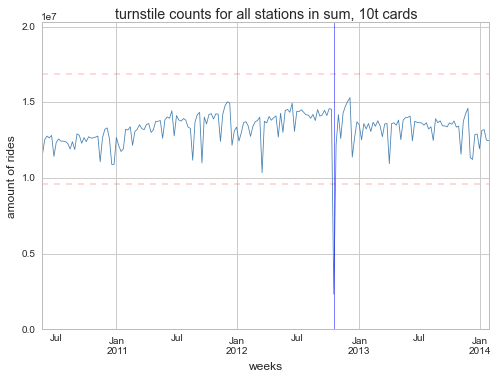

In [173]:
e1 = detectEvent(dp_all['10t'], plotEvents=1)

plt.xlabel('weeks')
plt.ylabel('amount of rides')
plt.title('turnstile counts for all stations in sum, 10t cards');

it is not hard to identify this event:  it was just when **Hurricane Sandy approached NYC**

# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

now: aggregate by ridership types

In [347]:
# summation
dp_all = dp.sum(axis='items')
dp_all.shape

(194, 23)

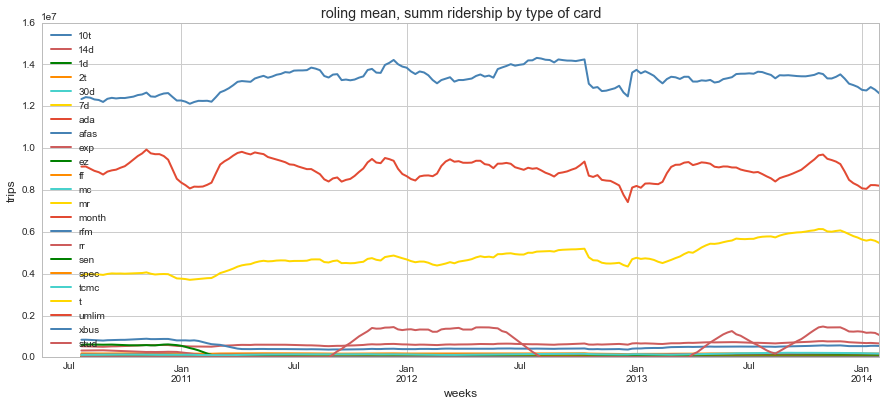

In [207]:
ax = pd.rolling_mean(dp_all, 10).plot(figsize=(15,6));
ax.set_title('roling mean, summ ridership by type of card')
ax.set_xlabel('weeks')
ax.set_ylabel('trips')

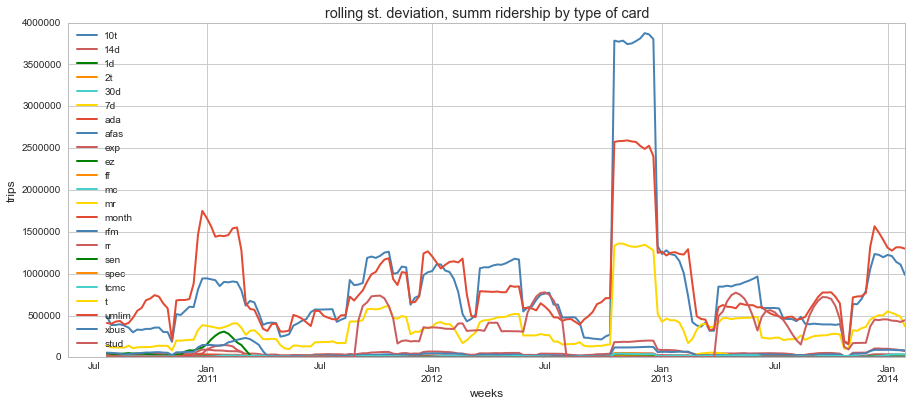

In [208]:
ax = pd.rolling_std(dp_all, 10).plot(figsize=(15,6))
ax.set_title('rolling st. deviation, summ ridership by type of card')
ax.set_xlabel('weeks')
ax.set_ylabel('trips')

In [206]:
# Augmented Dickey–Fuller test MacKinnon’s approximate p-values: low p-value means that series is stationery

for col in dp_all.columns:
    print col,' {0:.2f}'.format(sm.tsa.adfuller(dp_all[col])[1])

10t  0.00
14d  0.22
1d  0.23
2t  0.00
30d  0.00
7d  0.53
ada  0.00
afas  0.09
exp  0.03
ez  0.12
ff  0.54
mc  0.87
mr  0.93
month  0.55
rfm  0.23
rr  0.76
sen  0.74
spec  0.07
tcmc  0.04
t  0.00
umlim  0.00
xbus  0.38
stud  0.05


In [233]:
rmean = pd.rolling_mean(dp_all, 10)

ratio = (rmean.iloc[-1]/rmean.iloc[9])

print 'steadely increasing'
print ratio[ratio>1].head(10).sort_values(ascending=0)

print 
print 'steadely decreasing'
print ratio[ratio<1].head(10).sort_values(ascending=0)


steadely increasing
mr     24784.931
spec      70.182
sen        2.909
rr         2.593
7d         1.390
14d        1.252
mc         1.214
1d         1.111
30d        1.034
10t        1.022
dtype: float64

steadely decreasing
2t      0.934
ada     0.900
ff      0.819
umlim   0.809
rfm     0.650
month   0.579
afas    0.000
exp     0.000
ez      0.000
dtype: float64


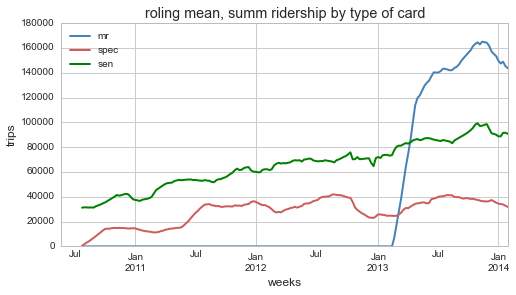

In [236]:
ax = pd.rolling_mean(dp_all[['mr','spec','sen']], 10).plot(figsize=(8,4));
ax.set_title('roling mean, summ ridership by type of card')
ax.set_xlabel('weeks')
ax.set_ylabel('trips')

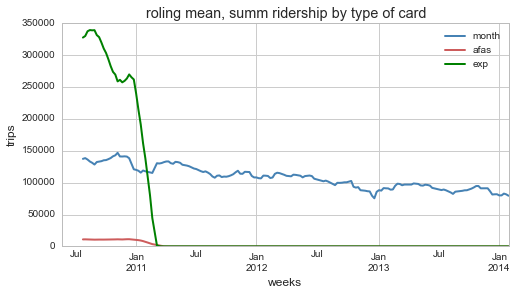

In [237]:
ax = pd.rolling_mean(dp_all[['rfm', 'month','afas','exp']], 10).plot(figsize=(8,4));
ax.set_title('roling mean, summ ridership by type of card')
ax.set_xlabel('weeks')
ax.set_ylabel('trips')

### MY Comment: 
lets don't count **Mail and Ride** cards as it looks like they started only in 2013. Apart of it, 
types spec, sen, rr, 7d, 14d, mc are stabely increase in popularity.

On the other hand, month, rfm, unlim are stabely decrease, while 'afas', 'exp' and 'ez' seems to be closed

# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [255]:
# first let's aggregate (summ) data by station, so we'll have one 600*194 DF

dp_st = dp.sum(axis='minor_axis').reindex()
print dp_st.shape
dp_st.head(2)

(194, 600)


,st1,st2,st3,st4,st5,st6,st7,st8,st9,st10,...,st591,st592,st593,st594,st595,st596,st597,st598,st599,st600
2010-05-23,126878.000,37306.000,6606.000,16378.000,18564.000,19987.000,12449.000,11091.000,10482.000,147187.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2010-05-30,149477.000,46464.000,6881.000,17408.000,19903.000,20625.000,13644.000,11659.000,11030.000,154826.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


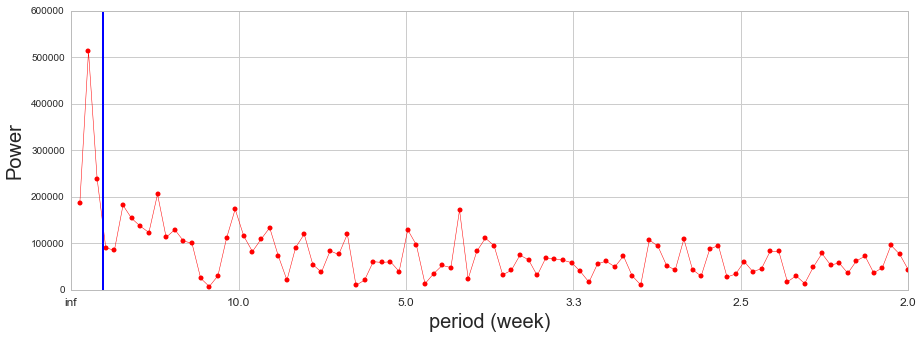

In [293]:
N = len(dp_st)

f = np.abs(np.fft.rfft(dp_st.st200))

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'ro', ms=5)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'r-', lw=.5);

ax.set_xticklabels([ "{:.1f}".format(1/x) for x in ax.get_xticks()], fontsize=12)
plt.xlabel("period (week)", fontsize=20)
plt.ylabel("Power", fontsize=20);
plt.axvline(1.0/52);

In [285]:
x = pd.Series(np.abs(np.fft.rfft(dp_st.st115))[1:])
print x.idxmax(), x.max()

1 270763.346115


looking at the plot above, we can assume that max periodicity is ~52 if point  #4 (index = 3) has maximum power. 
lets check that

In [304]:
stationNames = []
for station in dp_st.columns:
    x = pd.Series(np.abs(np.fft.rfft(dp_st[station]))[1:])
    if x.idxmax()==3:
        stationNames.append({'sid':station, 'power':x.max()})

print 'those 4 stations have max periodicity on'
print pd.DataFrame(stationNames).sort_values('power',ascending=0).head(4)

those 4 stations have max periodicity on
         power    sid
0  2980160.636    st1
12 2950388.929  st195
8  2931895.877  st151
15 2402218.581  st328


In [306]:
## well same result can be achieved through strait-forward approach

stationNames = []
for station in dp_st.columns:
    x = pd.Series(np.abs(np.fft.rfft(dp_st[station]))[1:])
    stationNames.append({'sid':station, 'power':x[3]})

print 'those 4 stations have max periodicity on'
print pd.DataFrame(stationNames).sort_values('power', ascending=0).head(4)

those 4 stations have max periodicity on
          power    sid
0   2980160.636    st1
194 2950388.929  st195
150 2931895.877  st151
327 2402218.581  st328


### So **stations 1, 195,  151, 328** have maximal annual periodicity

### We can also see strong monthly periodicity (index N44 in the table below)

In [309]:

stationNames = []
for station in dp_st.columns:
    x = pd.Series(np.abs(np.fft.rfft(dp_st[station]))[1:]).idxmax()
    stationNames.append({'sid':station, 'period':x})
    
pd.DataFrame(stationNames).period.value_counts()

0     239
1     233
44     58
3      36
2      10
29      9
6       5
7       3
18      2
10      2
23      1
14      1
9       1
Name: period, dtype: int64

# EXTRA CREDIT: Cluster. 
## Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
## Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

In [385]:
dp_all = dp.sum(axis='items')
dp_all.shape

#normalising stations
dp_stN = dp_st.apply(lambda x: (x-x.mean())/x.std(), 0)


In [387]:
stations = dp_stN.transpose()
stations.shape

(600, 194)

In [389]:
stations = mta.transpose(2,0,1).reshape(mta.shape[2], mta.shape[1]*data.shape[0]).T
stations = stations[stations.std(1)>0]

vals = ((stations.T - stations.mean(1))/stations.std(1)).T

In [391]:
np.random.seed(5)

km = KMeans(n_clusters=8)
km.fit(vals)

labels = km.labels_

In [399]:
sts = pd.DataFrame(stations)
sts['labels'] = labels

In [401]:
g1  = sts[sts['labels']==1]
g1.shape

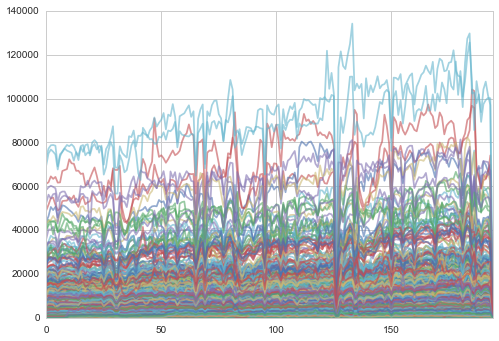

In [406]:
g1.transpose().plot(legend=0, alpha=0.6)
plt.title('k-mean series: group 1')

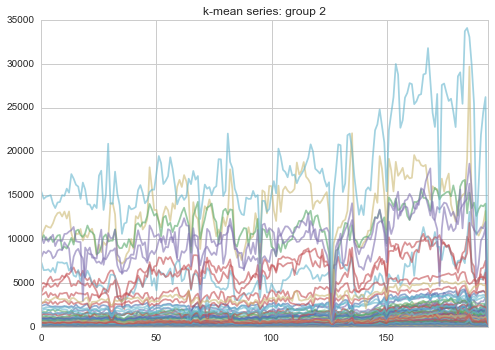

In [407]:
g2  = sts[sts['labels']==2]
g2.shape

g2.transpose().plot(legend=0, alpha=0.6)
plt.title('k-mean series: group 2')

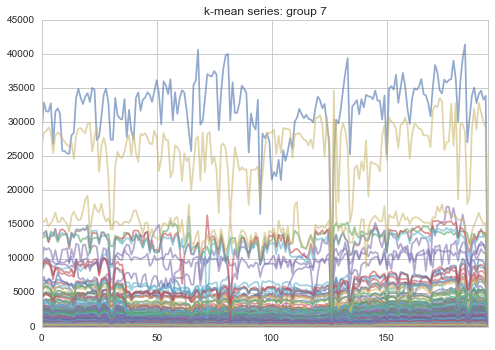

In [408]:
g8  = sts[sts['labels']==7]
g8.shape

g8.transpose().plot(legend=0, alpha=0.6)
plt.title('k-mean series: group 7')